# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [34]:
# Import numpy and pandas
import numpy as np
import pandas as pd

# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [35]:
# Run this code:

sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [36]:
sensor.head()


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [37]:
sensor.isnull().sum()
sensor.dropna(inplace=True)

How many rows and columns are in our data?

In [38]:
sensor.shape

(1751, 12)

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [39]:
time_index = pd.date_range(start='1/1/2018 00:00:00', end='1/1/2018 00:29:10', periods=sensor.shape[0])

Assign the time series index to the dataframe's index.

In [40]:
sensor.index = time_index

Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

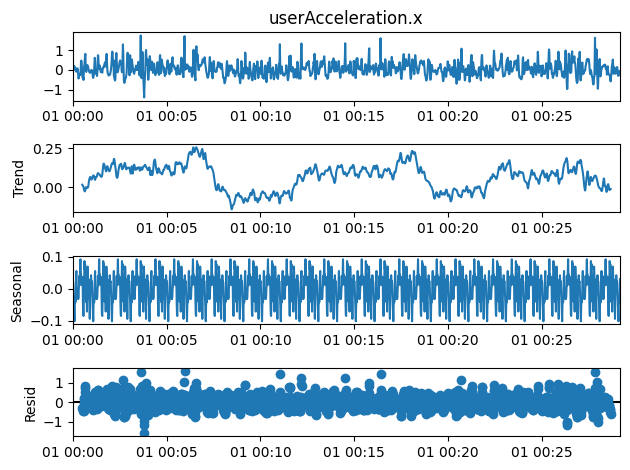

In [41]:
# Your code here:
# Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function.
# Descarga el submódulo `statsmodels.api`
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Descarga seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
# Realiza la descomposición de la serie temporal
# Asigna los parametros de la serie temporal y la frecuencia de 60
decomposition = seasonal_decompose(sensor['userAcceleration.x'], period=60)
# Grafica la descomposición
fig = decomposition.plot()
plt.show()







Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

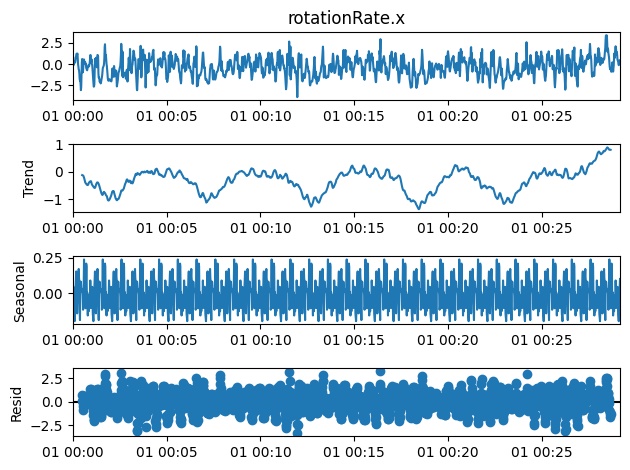

In [42]:
decomposition = seasonal_decompose(sensor['rotationRate.x'], period=60)
fig = decomposition.plot()
plt.show()


# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

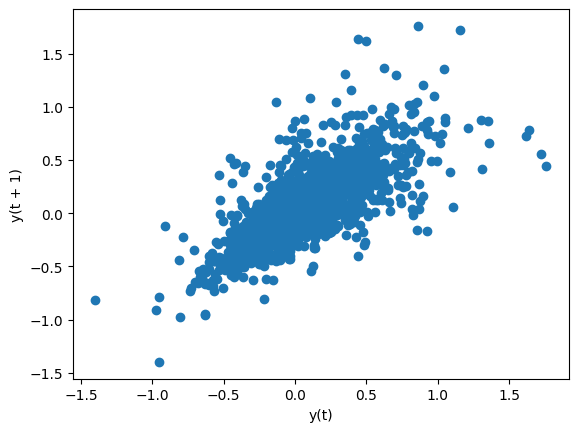

In [43]:
from pandas.plotting import lag_plot
lag_plot(sensor['userAcceleration.x'])
plt.show()

Create a lag plot for `rotationRate.x`

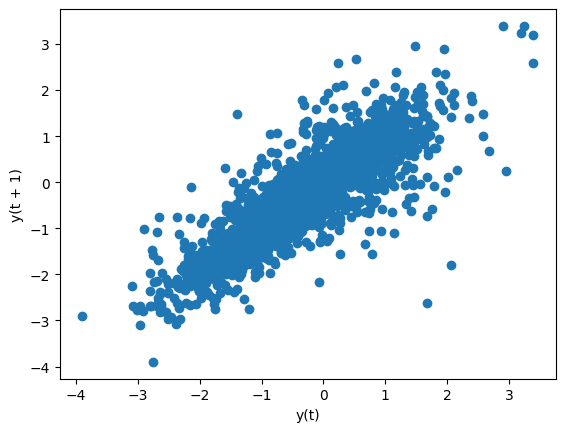

In [44]:
lag_plot(sensor['rotationRate.x'])
plt.show()

What are your conclusions from both visualizations?

### Your conclusions here:
### En el caso de `userAcceleration.x` se observa una correlación positiva entre los valores de la serie temporal y sus valores retrasados. En el caso de `rotationRate.x` no se observa una correlación entre los valores de la serie temporal y sus valores retrasados.




The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [45]:
from statsmodels.tsa.stattools import adfuller
adfuller(sensor['userAcceleration.x'])
adfuller(sensor['rotationRate.x'])

(-5.269860625086407,
 6.320230335912605e-06,
 25,
 1725,
 {'1%': -3.4341465551936534,
  '5%': -2.863216966926812,
  '10%': -2.567662770090317},
 2619.6049719981947)

What are your conclusions from this test?

## Your conclusions here:
### La prueba de Dickey Fuller Aumentada nos indica que ambas variables no son estacionarias, ya que el valor de p es mayor que 0.05. Por lo tanto, ambas variables tienen una tendencia y una estacionalidad. Por lo tanto, ambas variables no son estacionarias. 


Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

C:\Users\gdlcm\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  self._init_dates(dates, freq)
C:\Users\gdlcm\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  self._init_dates(dates, freq)


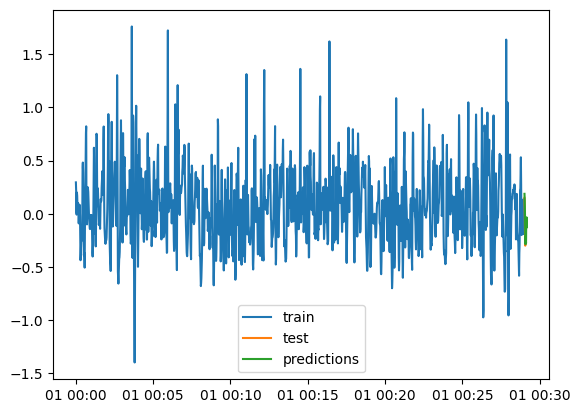

In [46]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(sensor['userAcceleration.x'], order=(2, 1, 0))
train = sensor['userAcceleration.x'][:-10]
test = sensor['userAcceleration.x'][-10:]
model_fit = model.fit(disp=False)
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

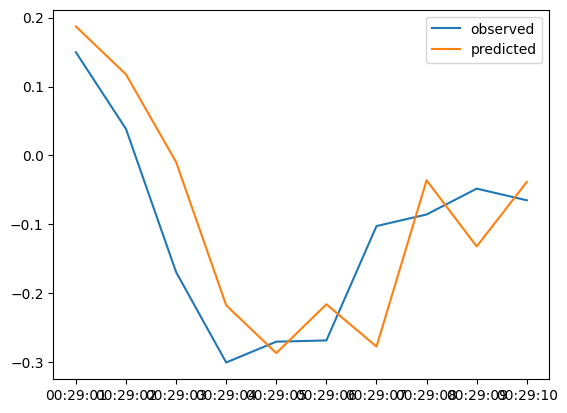

In [47]:
from statsmodels.tools.eval_measures import rmse
rmse(sensor['userAcceleration.x'][-10:], predictions)
plt.plot(sensor['userAcceleration.x'][-10:], label='observed')
plt.plot(predictions, label='predicted')
plt.legend()
plt.show()